In [1]:
# Cell 1: Imports and basic setup
import math
import json
from dataclasses import dataclass
from typing import Dict, Any

import numpy as np
import matplotlib.pyplot as plt

# Optional: for real embeddings (comment out if you don't want to download models)
try:
    from sentence_transformers import SentenceTransformer
    _embed_model = SentenceTransformer("all-MiniLM-L6-v2")
except Exception as e:
    _embed_model = None
    print("Embedding model unavailable; will fall back to dummy embeddings.")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

e:\Conestoga\Foundations of Machine Learning Frameworks\Sustainable AI\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\babut\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [17]:
# Cell 1: Imports and basic setup
import math
import json
from dataclasses import dataclass
from typing import Dict, Any

import numpy as np
import matplotlib.pyplot as plt

# Optional: for real embeddings (comment out if you don't want to download models)
try:
    from sentence_transformers import SentenceTransformer
    _embed_model = SentenceTransformer("all-MiniLM-L6-v2")
except Exception as e:
    _embed_model = None
    print("Embedding model unavailable; will fall back to dummy embeddings.")


In [19]:
# Cell 2: Tokenization and feature extraction
def tokenize_count(s: str) -> int:
    return len(s.strip().split())

def prompt_features(role: str, context: str, expectations: str) -> Dict[str, Any]:
    tokens = tokenize_count(role) + tokenize_count(context) + tokenize_count(expectations)
    punctuation_complexity = len([ch for ch in context if ch in ";:,."])
    complexity = min(1.0, (0.25 + math.log10(max(tokens, 1)) * 0.15 + punctuation_complexity * 0.01))
    sections = sum(1 for label in ["role", "context", "expectations"] if locals())
    return {"tokens": tokens, "complexity": complexity, "sections": sections}


In [20]:
# Cell 3: Energy estimation (simple calibrated proxy)
@dataclass
class Params:
    layers: int
    training_time_hours: float
    flops_per_hour: float
    hardware: str = "Generic"

def estimate_kwh(features: Dict[str, Any], params: Params) -> float:
    # Base energy from FLOPs, utilization, and a rough FLOPs->kWh conversion factor
    utilization = 0.6
    flops_to_kwh = 1e-12  # tune this to your hardware logs
    base_kwh = params.flops_per_hour * utilization * params.training_time_hours * flops_to_kwh

    # Adjust for prompt-dependent compute (sequence length & complexity)
    seq_factor = 1.0 + math.log10(max(1, features["tokens"])) * 0.25
    complexity_factor = 1.0 + features["complexity"] * 0.3
    layer_factor = 1.0 + (params.layers - 1) * 0.15

    return base_kwh * seq_factor * complexity_factor * layer_factor


In [21]:
# Cell 4: Embeddings and similarity
def embed_text(text: str) -> np.ndarray:
    # Prefer real model if available; else dummy embedding based on simple stats
    if _embed_model is not None:
        vec = _embed_model.encode([text], normalize_embeddings=True)[0]
        return np.array(vec, dtype=np.float32)
    # Dummy embedding: token count, log tokens, char length modulo
    t = tokenize_count(text)
    return np.array([t, math.log(1 + t), len(text) % 100], dtype=np.float32)

def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    na = np.linalg.norm(a)
    nb = np.linalg.norm(b)
    if na == 0 or nb == 0:
        return 0.0
    return float(np.dot(a, b) / (na * nb))


In [25]:
# Cell 5 (REPLACE): Stronger compressor + multi-variant optimizer (fixed)

STOPWORDS = set("""
a an the and or but so to of for in on with at by from as that which who whom whose
be am is are was were been being have has had do does did will would should can could
""".split())

def compact_sentence(s: str) -> str:
    s = " ".join(s.split())
    replacements = {
        "please ": "", " kindly ": "", " in order to ": " to ",
        " basically ": " ", " actually ": " ", " really ": " ",
        " step-by-step ": " stepwise "
    }
    for k, v in replacements.items():
        s = s.replace(k, v)
    s = s.replace(" where possible", "").replace(" as needed", "").replace(" if necessary", "")
    return s.strip()

def to_bullets(text: str) -> str:
    parts = [p.strip() for p in text.replace(";", ".").split(".") if p.strip()]
    bullets = []
    for p in parts:
        tokens = [t for t in p.split() if t.lower() not in STOPWORDS]
        if tokens:
            bullets.append("- " + " ".join(tokens))
    return "\n".join(bullets[:4])

def abbreviate_phrases(s: str) -> str:
    abbr = {
        "Provide": "Give",
        "Return": "Deliver",
        "include": "add",
        "avoid": "skip",
        "responses": "answers",
        "concise, accurate": "concise & accurate",
        "step-by-step reasoning": "stepwise reasoning"
    }
    for k, v in abbr.items():
        s = s.replace(k, v)
    return s

def compress_prompt(role: str, context: str, expectations: str, max_tokens: int = None):
    r = compact_sentence(role)
    c = compact_sentence(context)
    e = compact_sentence(expectations)

    c_bullets = to_bullets(c)
    e_bullets = to_bullets(e)
    r = abbreviate_phrases(r)

    candidate = {
        "role": r,
        "context": c_bullets if c_bullets else c,
        "expectations": e_bullets if e_bullets else e
    }

    if max_tokens is not None:
        def count_tokens(pr):
            return tokenize_count(pr["role"]) + tokenize_count(pr["context"]) + tokenize_count(pr["expectations"])

        def remove_shortest(lines):
            if len(lines) <= 1:
                return lines
            # FIX: use tokenize_count directly, do not wrap in len()
            lengths = [tokenize_count(l) if isinstance(l, str) else 0 for l in lines]
            idx = int(np.argmin(lengths))
            return lines[:idx] + lines[idx+1:]

        # Iteratively trim until under budget
        guard = 0
        while count_tokens(candidate) > max_tokens and guard < 20:
            guard += 1
            ctx_lines = candidate["context"].split("\n") if "\n" in candidate["context"] else [candidate["context"]]
            exp_lines = candidate["expectations"].split("\n") if "\n" in candidate["expectations"] else [candidate["expectations"]]

            if len(exp_lines) > 1:
                exp_lines = remove_shortest(exp_lines)
                candidate["expectations"] = "\n".join([l for l in exp_lines if l.strip()])
            elif len(ctx_lines) > 1:
                ctx_lines = remove_shortest(ctx_lines)
                candidate["context"] = "\n".join([l for l in ctx_lines if l.strip()])
            else:
                # Tighten wording one more time
                candidate["role"] = abbreviate_phrases(candidate["role"])
                candidate["context"] = abbreviate_phrases(candidate["context"])
                candidate["expectations"] = abbreviate_phrases(candidate["expectations"])
                break

    return candidate

def generate_variants(role: str, context: str, expectations: str, token_budget: int):
    variants = []
    variants.append(compress_prompt(role, context, expectations, max_tokens=token_budget))
    variants.append(compress_prompt(role, context + "; minimize verbosity; use bullets", expectations, max_tokens=token_budget))
    variants.append(compress_prompt(
        role.replace("You are an assistant that", "Assistant:"),
        context, expectations, max_tokens=token_budget
    ))
    variants.append(compress_prompt(role, expectations + "; keep answers short", context, max_tokens=token_budget))
    return variants

def improve_prompt(role: str, context: str, expectations: str, params: Params,
                   similarity_min: float = 0.85, reduction_pct: float = 0.3):
    original = f"{role}\n{context}\n{expectations}"
    before_features = prompt_features(role, context, expectations)
    before_kwh = estimate_kwh(before_features, params)

    target_tokens = max(1, int(before_features["tokens"] * (1.0 - reduction_pct)))
    pool = generate_variants(role, context, expectations, token_budget=target_tokens)

    best = None
    best_score = (float("inf"),)  # tuple for consistent comparison
    for cand in pool:
        cand_text = f"{cand['role']}\n{cand['context']}\n{cand['expectations']}"
        sim = cosine_sim(embed_text(original), embed_text(cand_text))
        af = prompt_features(cand["role"], cand["context"], cand["expectations"])
        akwh = estimate_kwh(af, params)
        score = (akwh, -sim, af["tokens"])
        if sim >= similarity_min and score < best_score:
            best = (cand, af, akwh, sim)
            best_score = score

    if best is None:
        # Fallback: closest to similarity_min, then lowest energy
        candidates = []
        for cand in pool:
            cand_text = f"{cand['role']}\n{cand['context']}\n{cand['expectations']}"
            sim = cosine_sim(embed_text(original), embed_text(cand_text))
            af = prompt_features(cand["role"], cand["context"], cand["expectations"])
            akwh = estimate_kwh(af, params)
            candidates.append((abs(similarity_min - sim), akwh, af["tokens"], cand, af, akwh, sim))
        candidates.sort(key=lambda x: (x[0], x[1], x[2]))
        _, _, _, cand, af, akwh, sim = candidates[0]
        best = (cand, af, akwh, sim)

    improved, after_features, after_kwh, sim = best

    return {
        "improved": improved,
        "predicted_kwh_before": before_kwh,
        "predicted_kwh_after": after_kwh,
        "similarity": sim,
        "features_before": before_features,
        "features_after": after_features
    }


In [26]:
# Cell 6: Actions
def submit(role: str, context: str, expectations: str, params: Params) -> Dict[str, Any]:
    f = prompt_features(role, context, expectations)
    kwh = estimate_kwh(f, params)
    return {"predicted_kwh": kwh, "features": f, "assumptions": {"utilization": 0.6}}

def improve(role: str, context: str, expectations: str, params: Params,
            similarity_min: float = 0.9) -> Dict[str, Any]:
    return improve_prompt(role, context, expectations, params, similarity_min)


In [27]:
# Cell 7 (UPDATE): Sample run with target reduction
role = "You are an assistant that writes concise, accurate answers for developers."
context = ("Provide step-by-step reasoning only when asked. Focus on clarity, "
           "avoid redundancy; include code blocks where helpful; keep responses short.")
expectations = "Return actionable guidance and optimized prompts; cite assumptions clearly."

params = Params(layers=4, training_time_hours=2.0, flops_per_hour=1e20, hardware="A100")

result_submit = submit(role, context, expectations, params)
result_improve = improve(role, context, expectations, params, similarity_min=0.85)

print("Prediction (submit):")
print(json.dumps(result_submit, indent=2))
print("\nImprovement:")
print(json.dumps({
    "predicted_kwh_before": result_improve["predicted_kwh_before"],
    "predicted_kwh_after": result_improve["predicted_kwh_after"],
    "similarity": result_improve["similarity"],
    "improved": result_improve["improved"],
    "features_before": result_improve["features_before"],
    "features_after": result_improve["features_after"]
}, indent=2))


Prediction (submit):
{
  "predicted_kwh": 282513749.2028351,
  "features": {
    "tokens": 39,
    "complexity": 0.5386596910539749,
    "sections": 3
  },
  "assumptions": {
    "utilization": 0.6
  }
}

Improvement:
{
  "predicted_kwh_before": 282513749.2028351,
  "predicted_kwh_after": 267192457.41773674,
  "similarity": 0.9023110866546631,
  "improved": {
    "role": "You are an assistant that writes concise & accurate answers for developers.",
    "context": "- Return actionable guidance optimized prompts",
    "expectations": "- Provide stepwise reasoning only when asked"
  },
  "features_before": {
    "tokens": 39,
    "complexity": 0.5386596910539749,
    "sections": 3
  },
  "features_after": {
    "tokens": 25,
    "complexity": 0.45969100130080565,
    "sections": 3
  }
}


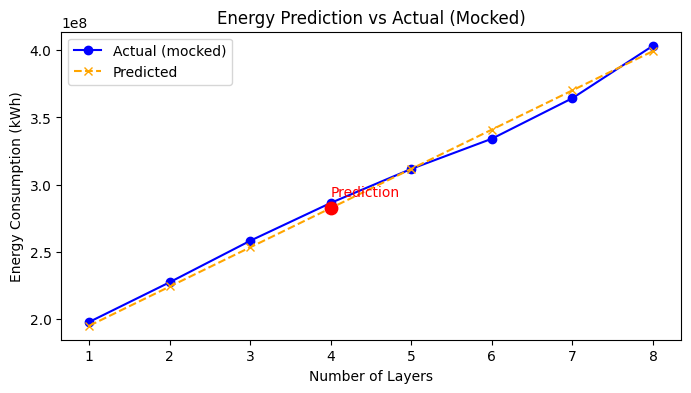

In [28]:
# Cell 8: Chart across layers
def energy_by_layers(base_params: Params, features: Dict[str, Any], base_pred_kwh: float):
    layers_list = list(range(1, 9))
    predicted_series = []
    actual_series = []
    for L in layers_list:
        p = Params(layers=L,
                   training_time_hours=base_params.training_time_hours,
                   flops_per_hour=base_params.flops_per_hour,
                   hardware=base_params.hardware)
        kwh_pred = estimate_kwh(features, p)
        predicted_series.append(kwh_pred)
        # Mock actuals: add small noise
        actual_series.append(kwh_pred * (0.98 + np.random.rand() * 0.04))
    return layers_list, predicted_series, actual_series

layers_list, pred, actual = energy_by_layers(params, result_submit["features"], result_submit["predicted_kwh"])

plt.figure(figsize=(8, 4))
plt.plot(layers_list, actual, marker="o", color="blue", label="Actual (mocked)")
plt.plot(layers_list, pred, marker="x", linestyle="--", color="orange", label="Predicted")
plt.title("Energy Prediction vs Actual (Mocked)")
plt.xlabel("Number of Layers")
plt.ylabel("Energy Consumption (kWh)")
plt.legend()
# Highlight current prediction point
current_L = params.layers
current_idx = layers_list.index(current_L)
plt.scatter([current_L], [pred[current_idx]], s=80, color="red", zorder=5)
plt.text(current_L, pred[current_idx]*1.03, "Prediction", color="red")
plt.show()


In [29]:
# Cell 9: Diff-style view and KPIs
orig_text = f"{role}\n{context}\n{expectations}"
imp = result_improve["improved"]
imp_text = f"{imp['role']}\n{imp['context']}\n{imp['expectations']}"

print("Original prompt:\n---\n", orig_text)
print("\nImproved prompt:\n---\n", imp_text)

delta_kwh = result_improve["predicted_kwh_before"] - result_improve["predicted_kwh_after"]
print(f"\nEnergy delta: {delta_kwh:.4f} kWh ({(delta_kwh / result_improve['predicted_kwh_before'])*100:.2f}% reduction)")
print(f"Similarity: {result_improve['similarity']:.3f}")
print("Features (before → after):", result_improve["features_before"], "→", result_improve["features_after"])


Original prompt:
---
 You are an assistant that writes concise, accurate answers for developers.
Provide step-by-step reasoning only when asked. Focus on clarity, avoid redundancy; include code blocks where helpful; keep responses short.
Return actionable guidance and optimized prompts; cite assumptions clearly.

Improved prompt:
---
 You are an assistant that writes concise & accurate answers for developers.
- Return actionable guidance optimized prompts
- Provide stepwise reasoning only when asked

Energy delta: 15321291.7851 kWh (5.42% reduction)
Similarity: 0.902
Features (before → after): {'tokens': 39, 'complexity': 0.5386596910539749, 'sections': 3} → {'tokens': 25, 'complexity': 0.45969100130080565, 'sections': 3}
